In [22]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_1_open_solver_1_numba.json")
data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")

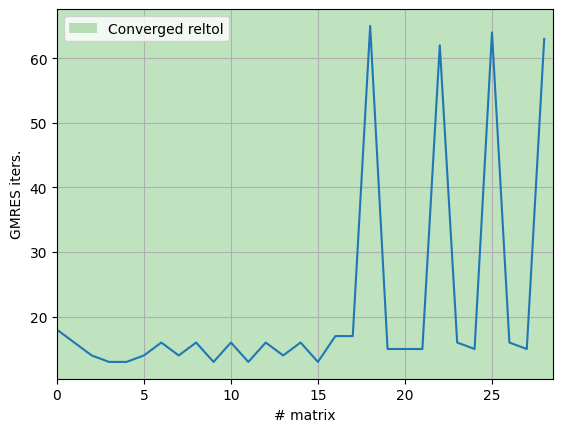

In [23]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [24]:
mat_idx = 14
get_gmres_iterations(data)[mat_idx]

16

In [25]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 27
sliding = 45
open = 0
transition = 36
total = 72


In [26]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [27]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_1 import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)
mat = mat[reorder]

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

Solve  took: 0.19


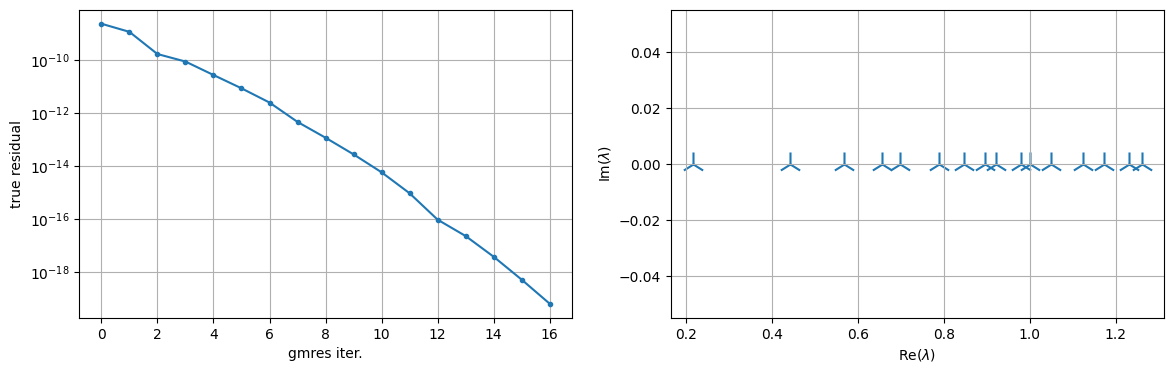

In [28]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

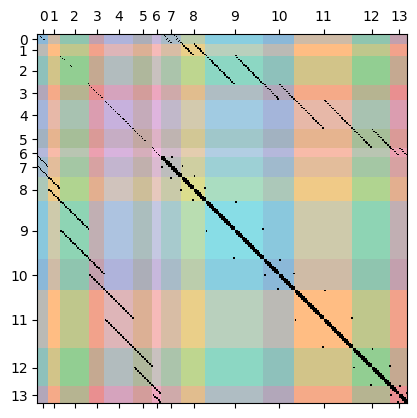

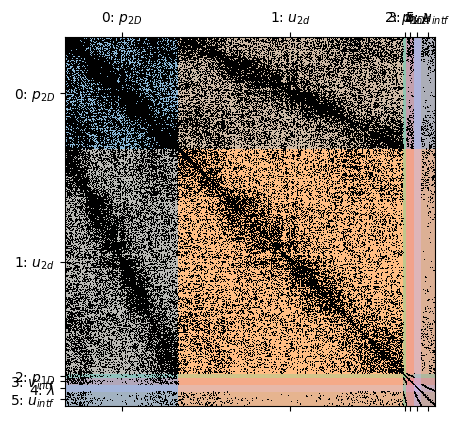

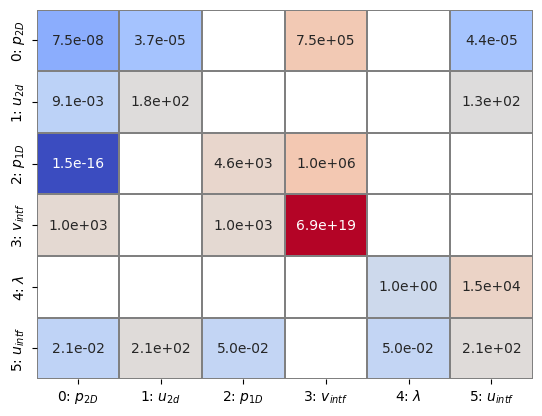

In [29]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)

J[[4, 5]].color_spy(False)

J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

Solve  took: 0.07


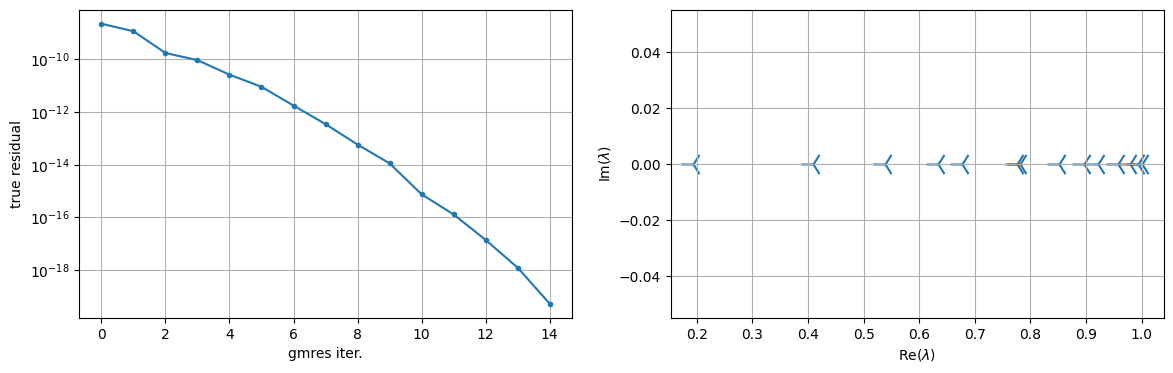

In [30]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization

schema_1 = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema_45_1 = SolveSchema(
    groups=[4, 5],
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Solve  took: 0.0


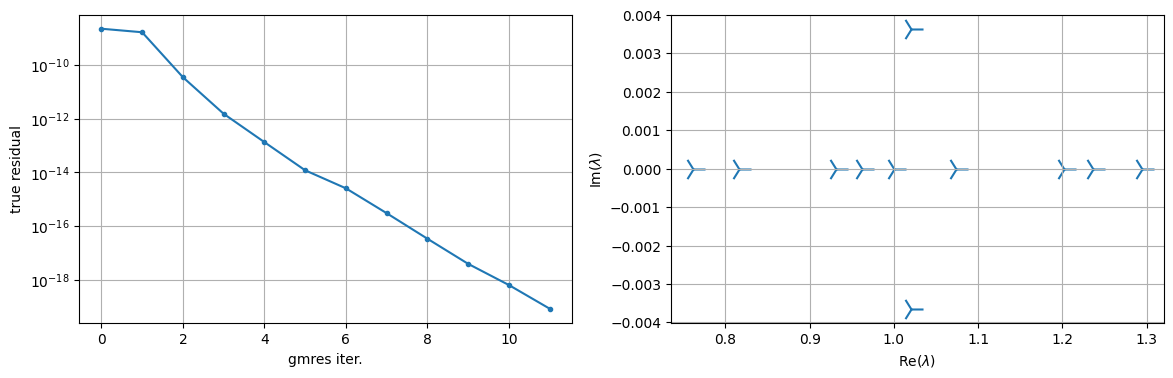

In [31]:
schema_5_4 = SolveSchema(
    groups=[5],
    solve='use_invertor',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(abs(bmat.mat)) / 6,
    # invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    # invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),


    complement=SolveSchema(
        groups=[4],
        # solve=lambda bmat: inv_block_diag_2x2(bmat.mat),
        solve=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    )
)

mat_permuted, prec = make_solver(schema=schema_5_4, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Note: It's not good enough to just take a diagonal approximation of J55

Solve  took: 0.08


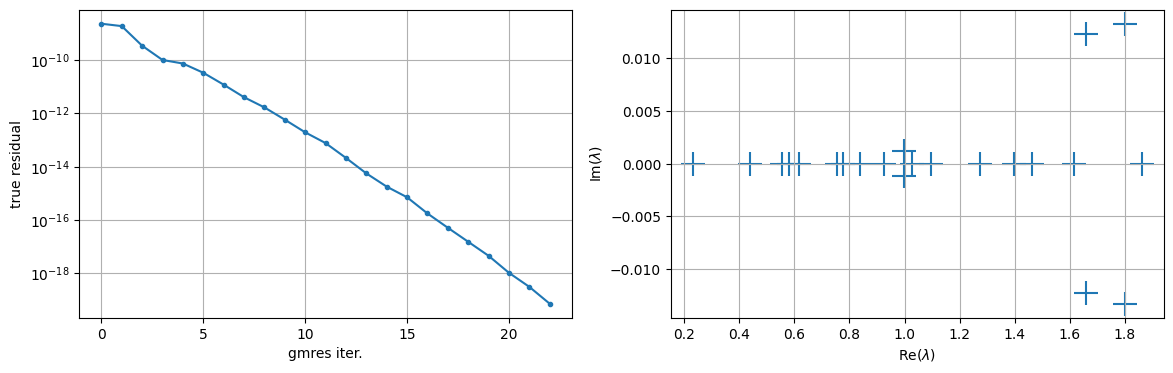

In [44]:
schema_5_4_1 = SolveSchema(
    groups=[5],
    # solve='direct',
    solve='use_invertor',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    # invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),

    complement=SolveSchema(
        groups=[4],
        solve='use_invertor',
        # invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
        invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),

        complement=schema_1,
    ),
    # complement=schema_1
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

(ABOVE SHOULD FAIL without lumping for 2D and 3D)

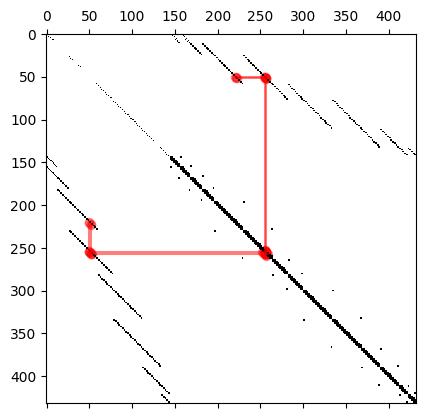

In [33]:
# %matplotlib tk


tmp = J[[4, 5]].mat
spy(tmp, show=False)

row_start = 50
col_start = 50
recursion = 4

def connect_vertices(mat, mat_t, row_start, col_start, recursion=1, transposed=False):
    if recursion == 0:
        return
    
    mat_t = mat_t.tocsr()
    mat = mat.tocsr()    
    cols = mat[row_start].indices
    if not transposed:
        plt.plot([min(cols), max(cols)], [row_start, row_start], alpha=0.5, color='red')
        plt.scatter(cols, [row_start] * len(cols), color='red', alpha=0.3)
    else:
        plt.plot([row_start, row_start], [min(cols), max(cols)], alpha=0.5, color='red')
        plt.scatter([row_start] * len(cols), cols, color='red', alpha=0.3)

    col = cols[np.argmax(abs(cols - col_start))]
    connect_vertices(mat_t, mat, row_start=col, col_start=row_start, recursion=recursion-1, transposed=not transposed)

connect_vertices(tmp, tmp.T, row_start=row_start, col_start=col_start, recursion=recursion)
connect_vertices(tmp.T, tmp, row_start=col_start, col_start=row_start, recursion=recursion, transposed=True)

3d problem with 1 fracture?

Scalable?

Lumping

what I proposed

In [34]:
from preconditioner_mech import build_mechanics_stabilization

mech_stab = build_mechanics_stabilization(model, J, build_schur=False)

print(cond(J[[4, 5]].mat @ mech_stab)) # First is small
print(cond(mech_stab @ J[[4, 5]].mat)) # This is large

39302.51360142974
93706.82766080278


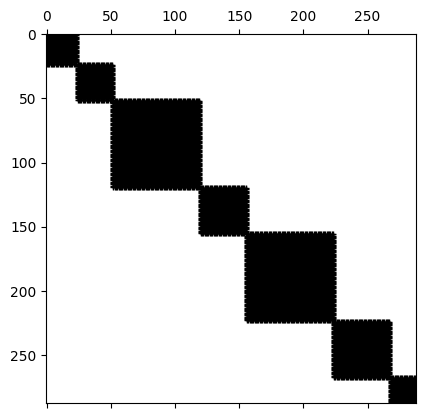

In [35]:
spy(J[[5]].block_diag_inv())

Below should fail for 3d. It shows that block diag inv is not enough due to connections between different fractures

Solve  took: 0.07


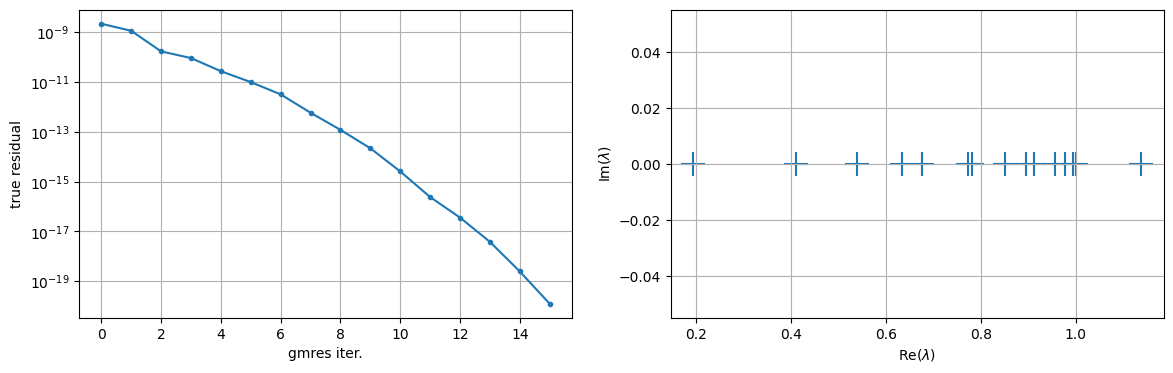

In [36]:
# Block diag inv

schema_45_1 = SolveSchema(
    groups=[5],
    solve=lambda x: x.block_diag_inv(),
    invertor=lambda x: x.block_diag_inv(),
    complement=SolveSchema(
        groups=[4],
        solve=lambda x: x.block_diag_inv(),
        invertor=lambda x: x.block_diag_inv(),
        complement=schema_1,
    )
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), logx_eigs=False)

Below fails in 3D without lumping

Solve  took: 0.3


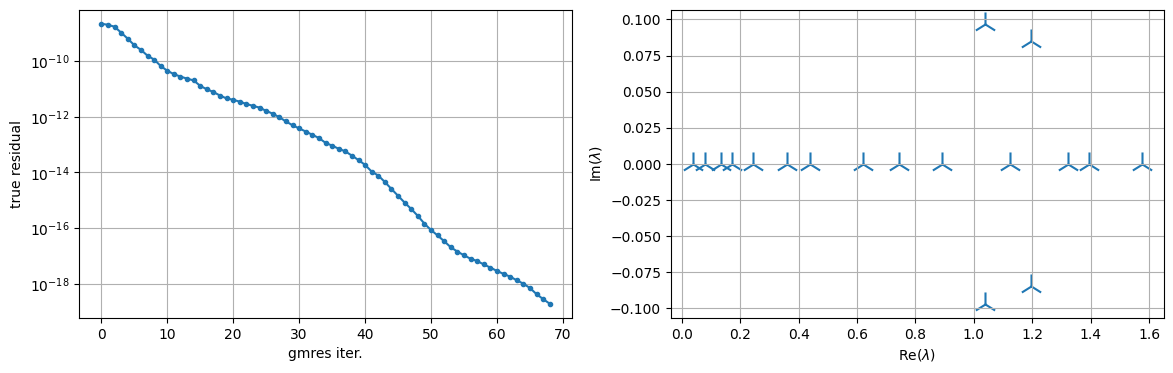

In [46]:
schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve='direct',
    # invertor=lambda x: scipy.sparse.eye(x.shape[0]),

    invertor=lambda: build_mechanics_stabilization(model, J, lump=True),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

But works with lumping.
In 2D, no difference between with/without lumping.

Solve  took: 0.25


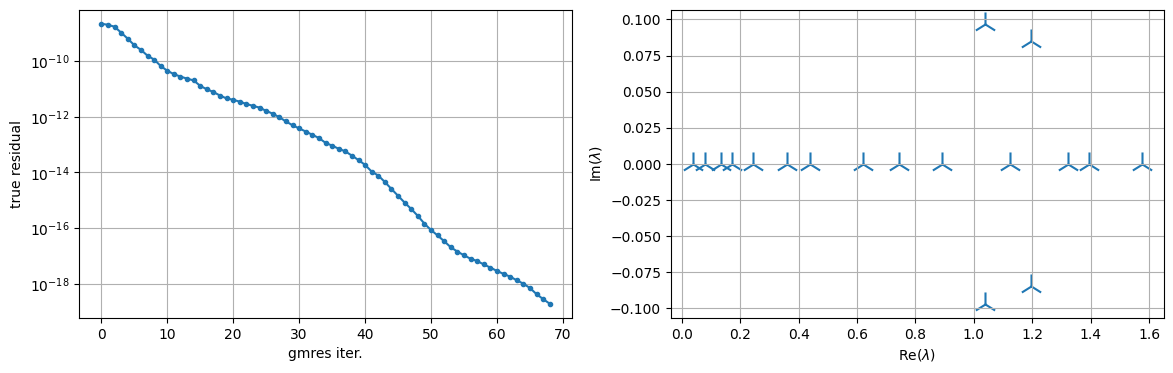

In [38]:
schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve='direct',
    # invertor=lambda x: scipy.sparse.eye(x.shape[0]),

    invertor=lambda: build_mechanics_stabilization(model, J, lump=True),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Below is slightly better than above for 3D. And much better for 2D.

Solve  took: 0.08


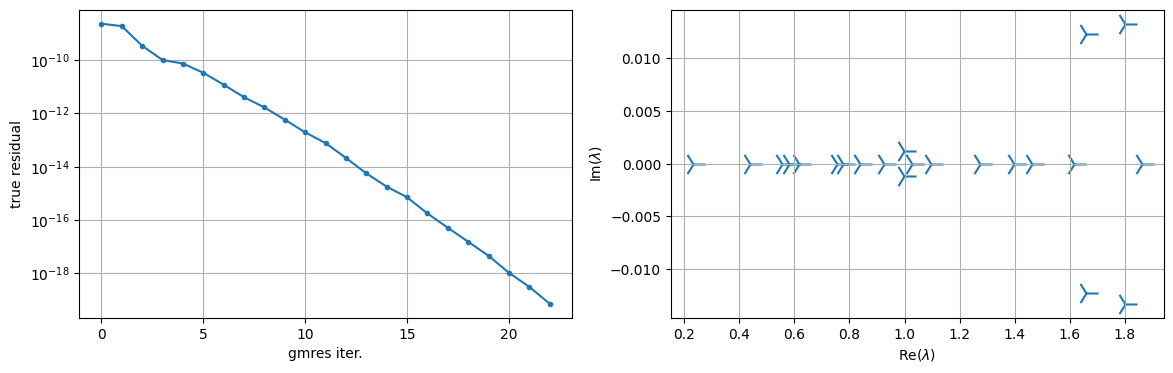

In [50]:
schema_5_4_1 = SolveSchema(
    groups=[5],
    solve='use_invertor',
    # invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),
    complement=SolveSchema(
        groups=[4],
        solve='use_invertor',
        invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
        complement=schema_1,
    ),
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

(ABOVE SHOULD FAIL without lumping of J55)

# How to solve blocks 4 and 5 not by a direct solver?

Solve  took: 0.0


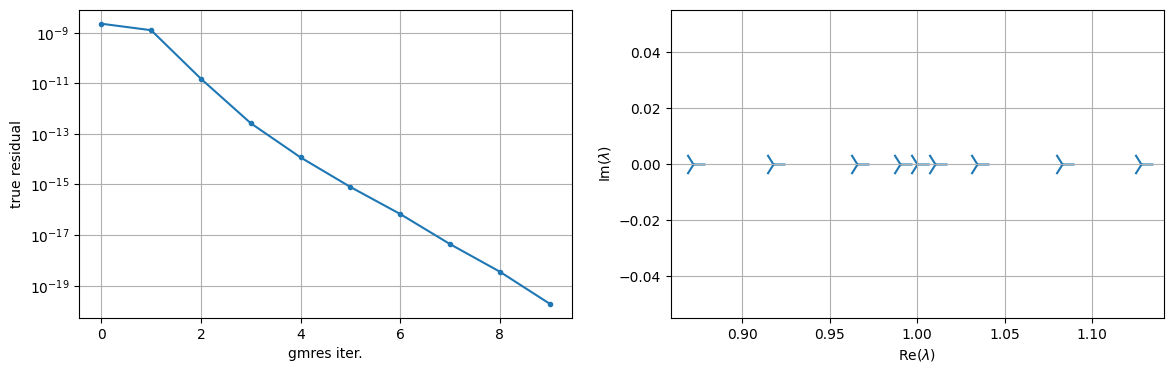

In [40]:
schema_45 = SolveSchema(
    groups=[4, 5],
    solve=lambda bmat: build_mechanics_stabilization(model=model, bmat=bmat, build_schur=False),
)

mat_permuted, prec = make_solver(schema=schema_45, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))